In [ ]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List, Tuple
from scipy.optimize import curve_fit

In [ ]:
dict_gates = {"H": lambda args: np.array([[1, 1], [1,-1]], dtype = np.complex64) / np.sqrt(2),
              "X": lambda args: np.array([[0, 1], [1, 0]], dtype = np.complex64),
              "Z": lambda args: np.array([[1, 0], [0, -1]], dtype = np.complex64),
              "Y": lambda args: np.array([[0, -1j], [1j, 0]], dtype = np.complex64),
              "CNOT": lambda args: np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]], dtype = np.complex64),
              "RX": lambda theta: np.array([[np.cos(theta / 2), - 1j * np.sin(theta / 2)],[- 1j * np.sin(theta / 2), np.cos(theta / 2)]], dtype = np.complex64),
              "RY": lambda theta: np.array([[np.cos(theta / 2), -np.sin(theta / 2)],[np.sin(theta / 2), np.cos(theta / 2)]], dtype = np.complex64),
              "RZ": lambda theta: np.array([[np.exp(-1j * theta / 2), 0],[0, np.exp(1j * theta / 2)]], dtype = np.complex64),
              "CP": lambda theta: np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, np.exp(1j * theta)]]),
              "SWAP": lambda args: np.array([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]], dtype = np.complex64),
              "CZ": lambda args: np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, -1]], dtype = np.complex64)}

type_gate = {"H": 0, "X": 0, "Y": 0, "Z": 0, "RX": 0, "RY": 0, "RZ": 0, "CNOT": 1, "CP": 1, "SWAP": 1, "CZ": 1}
letters_0 = ["H", "X", "Y", "Z", "RX", "RY", "RZ"]
letters_1 = ["CNOT", "CP", "SWAP", "CZ"]
letters = letters_0 + letters_1

In [ ]:
def trace(state):
  """
  Need to redefine accurately the trace
  """
  N = np.prod(state.shape)
  nn = int(np.sqrt(N))
  return np.trace(np.reshape(state, (nn, nn)))

In [ ]:
relaxation = lambda p: [np.array([[1, 0],
                                  [0, np.sqrt(1 - p)]], dtype = np.complex64),
                       np.array([[0, np.sqrt(p)],
                                  [0, 0]], dtype = np.complex64)]

pure_dephasing = lambda p: [np.array([[np.sqrt(1 - p), 0],
                        [0, np.sqrt(1 - p)]], dtype = np.complex64),
                       np.array([[np.sqrt(p), 0],
                        [0, -np.sqrt(p)]], dtype = np.complex64)]

depolarizing = lambda p: [np.array([[np.sqrt(1 - p), 0],
                        [0, np.sqrt(1 - p)]], dtype = np.complex64),
                         np.array([[0, np.sqrt(p / 3)],
                          [np.sqrt(p / 3), 0]], dtype = np.complex64),
                         np.array([[0, -1j * np.sqrt(p / 3)],
                          [1j * np.sqrt(p / 3), 0]], dtype = np.complex64),
                         np.array([[np.sqrt(p / 3), 0],
                        [0, -np.sqrt(p / 3)]], dtype = np.complex64)]

bit_flip = lambda p: [np.array([[np.sqrt(1 - p), 0],
                        [0, np.sqrt(1 - p)]], dtype = np.complex64),
                       np.array([[0, np.sqrt(p)],
                          [np.sqrt(p), 0]], dtype = np.complex64)]

In [ ]:
dict_noise = [relaxation, pure_dephasing, depolarizing, bit_flip]

In [ ]:
class StateVector:

    def __init__(self, n_qubit: int):
        """
        Initialize the state vector with the specified number of qubits.
        """
        self.n = n_qubit
        self.state = np.zeros(2**n_qubit, dtype=np.complex64)
        self.state[0] = 1  # Initial state |0, 0, ..., 0>
        self.state = np.reshape(self.state, (2,) * n_qubit)

    def apply(self, gate_input: np.ndarray, qubits: List[int], noise: bool):
        """
        Apply the given gate to the specified qubits with optional noise.

        Args:
            gate_input (np.ndarray): The gate matrix.
            qubits (List[int]): The qubits to apply the gate to.
            noise (bool): Flag indicating whether to apply noise.

        Raises:
            ValueError: If the length of qubits is invalid or if gate_input dimensions are incorrect.
        """
        m = len(qubits)
        if m <= 0 or m > self.n // 2:
            raise ValueError("Invalid number of qubits")

        M = int(2**m)
        gate_Kraus = np.tensordot(gate_input, np.conj(gate_input), axes=0) if not noise else \
                     sum(np.tensordot(g, np.conj(g), axes=0) for g in gate_input)

        if gate_Kraus.shape != (M, M, M, M):
            raise ValueError("Invalid gate_input dimensions")

        self.state = np.moveaxis(self.state, qubits + [q + self.n // 2 for q in qubits], range(2 * m))
        self.state = np.reshape(self.state, [M] + [M] + [2**(self.n - 2 * m)])
        self.state = np.tensordot(gate_Kraus, self.state, axes=([1, 3], [0, 1]))  # Adjusted contraction
        self.state = np.reshape(self.state, (2,) * self.n)
        self.state = np.moveaxis(self.state, range(2 * m), qubits + [q + self.n // 2 for q in qubits])

    def __repr__(self):
      return str(self.state)

In [ ]:
class QuantumCircuit:

  def __init__(self, n_qubit, list_gates = []): # allows to define a circuit by some initial list of gates

    self.n = n_qubit
    self.gates = list_gates

  def simulate(self, p):
    state = StateVector(2 * self.n) # 2 * n_qubits to simulate noise
    time_stamp = time()
    for gate, args, qubits in self.gates:
      state.apply(dict_gates[gate](args), qubits, False)
      for q in qubits:
        idx = np.random.randint(len(dict_noise))
        state.apply(dict_noise[0](p), [0], True)
    return state, time() - time_stamp

  def random_circuit(self, depth):
    for i in range(depth):
      for q in range(self.n):
        its = np.random.choice([0, 1, 2])
        if its == 0:
          self.gates.append(("RX", np.random.uniform(low = 0, high = 2 * np.pi), [q]))
        elif its == 1:
          self.gates.append(("RY", np.random.uniform(low = 0, high = 2 * np.pi), [q]))
        elif its == 2:
          self.gates.append(("RZ", np.random.uniform(low = 0, high = 2 * np.pi), [q]))

        if q < self.n - 1 and (q - i) % 2 == 0:
          self.gates.append(("CNOT", None, [q, q+1]))

  def H_wall(self):
    for k in range(self.n):
      self.gates.append(("H", None, [k]))

  def QFT(self):

    def step_QFT(n_qubit):
      self.gates.append(("H", None, [n_qubit]))
      if n_qubit >= 1:
        for k in range(1, n_qubit):
          self.gates.append(("CP", np.pi / 2**k, [n_qubit, n_qubit - k]))
        step_QFT(n_qubit - 1) # recursive construction

    step_QFT(self.n - 1)

  def benchmark(self, m, p):
    self.gates = []
    state = StateVector(2 * self.n) # 2 * n_qubits to simulate noise
    for k in range(m): # define the gates

      if self.n >= 2:
        idx = np.random.randint(len(letters))
      else:
        idx = np.random.randint(len(letters_0))


      if type_gate[letters[idx]] == 0:
        qubits = [np.random.randint(self.n)]
      elif type_gate[letters[idx]] == 1:
        qubits = [np.random.randint(self.n)]
        qubits.append(np.random.choice([k for k in range(self.n) if k != qubits[0]]))

      self.gates.append((letters[idx], np.random.uniform(low = 0, high = 2 * np.pi), qubits)) # all the arguments are angles

    for gate, args, qubits in self.gates: # apply in the direct order
      state.apply(dict_gates[gate](args), qubits, False)
      for q in qubits:
        idx = np.random.randint(len(dict_noise))
        state.apply(dict_noise[0](p), [0], True)

    self.gates.reverse() # apply in the reverse order
    for gate, args, qubits in self.gates:
      state.apply(np.conj(dict_gates[gate](args)).T, qubits, False)
      for q in qubits:
        idx = np.random.randint(len(dict_noise))
        state.apply(dict_noise[0](p), [0], True)

    return np.abs(state.state[(0,) * (2 * self.n)])**2  # fidelity

**Test Hadamard gate**

In [ ]:
n_qubit = 2
p = 0.0
list_gates = [("H", None, [0])]

circuit = QuantumCircuit(n_qubit, list_gates)

state, duration = circuit.simulate(p)

In [ ]:
state

[[[[0.49999997+0.j 0.        +0.j]
   [0.49999997+0.j 0.        +0.j]]

  [[0.        +0.j 0.        +0.j]
   [0.        +0.j 0.        +0.j]]]


 [[[0.49999997+0.j 0.        +0.j]
   [0.49999997+0.j 0.        +0.j]]

  [[0.        +0.j 0.        +0.j]
   [0.        +0.j 0.        +0.j]]]]

In [ ]:
print("Trace of the state:",trace(state.state))

Trace of the state: (0.99999994+0j)


In [ ]:
print("Duration:", duration)

Duration: 0.004083156585693359


In [ ]:
n_qubit = 2
p = 1.0
list_gates = [("H", None, [0])]

circuit = QuantumCircuit(n_qubit, list_gates)

state, duration = circuit.simulate(p)

In [ ]:
state

[[[[0.99999994+0.j 0.        +0.j]
   [0.        +0.j 0.        +0.j]]

  [[0.        +0.j 0.        +0.j]
   [0.        +0.j 0.        +0.j]]]


 [[[0.        +0.j 0.        +0.j]
   [0.        +0.j 0.        +0.j]]

  [[0.        +0.j 0.        +0.j]
   [0.        +0.j 0.        +0.j]]]]

In [ ]:
print("Trace of the state:",trace(state.state))

Trace of the state: (0.99999994+0j)


In [ ]:
print("Duration:", duration)

Duration: 0.002275228500366211


**Test X gate**

In [ ]:
n_qubit = 2
p = 0.0
list_gates = [("X", None, [0])]

circuit = QuantumCircuit(n_qubit, list_gates)

state, duration = circuit.simulate(p)

In [ ]:
state

[[[[0.+0.j 0.+0.j]
   [0.+0.j 0.+0.j]]

  [[0.+0.j 0.+0.j]
   [0.+0.j 0.+0.j]]]


 [[[0.+0.j 0.+0.j]
   [1.+0.j 0.+0.j]]

  [[0.+0.j 0.+0.j]
   [0.+0.j 0.+0.j]]]]

In [ ]:
print("Trace of the state:",trace(state.state))

Trace of the state: (1+0j)


In [ ]:
print("Duration:", duration)

Duration: 0.0006082057952880859


In [ ]:
n_qubit = 1
p = 0.0
list_gates = [("X", None, [0])]

circuit = QuantumCircuit(n_qubit, list_gates)

state, duration = circuit.simulate(p)

In [ ]:
state

[[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]

In [ ]:
print("Trace of the state:",trace(state.state))

Trace of the state: (1+0j)


In [ ]:
print("Duration:", duration)

Duration: 0.0016112327575683594


**Bell State Test**

In [ ]:
n_qubit = 2
p = 0.0
list_gates = [("H", None, [0]), ("CNOT", None, [0,1])]

circuit = QuantumCircuit(n_qubit, list_gates)

state, duration = circuit.simulate(p)

In [ ]:
state.state

array([[[[0.49999997+0.j, 0.        +0.j],
         [0.        +0.j, 0.49999997+0.j]],

        [[0.        +0.j, 0.        +0.j],
         [0.        +0.j, 0.        +0.j]]],


       [[[0.        +0.j, 0.        +0.j],
         [0.        +0.j, 0.        +0.j]],

        [[0.49999997+0.j, 0.        +0.j],
         [0.        +0.j, 0.49999997+0.j]]]], dtype=complex64)

In [ ]:
print("Trace of the state:",trace(state.state))

Trace of the state: (0.99999994+0j)


In [ ]:
print("Duration:", duration)

Duration: 0.00922393798828125


In [ ]:
n_qubit = 2
p = 1.0
list_gates = [("H", None, [0]), ("CNOT", None, [0,1])]

circuit = QuantumCircuit(n_qubit, list_gates)

state, duration = circuit.simulate(p)

In [ ]:
state

[[[[0.99999994+0.j 0.        +0.j]
   [0.        +0.j 0.        +0.j]]

  [[0.        +0.j 0.        +0.j]
   [0.        +0.j 0.        +0.j]]]


 [[[0.        +0.j 0.        +0.j]
   [0.        +0.j 0.        +0.j]]

  [[0.        +0.j 0.        +0.j]
   [0.        +0.j 0.        +0.j]]]]

In [ ]:
print("Trace of the state:",trace(state.state))

Trace of the state: (0.99999994+0j)


In [ ]:
print("Duration:", duration)

Duration: 0.0023665428161621094


## Randomized Benchmarking

**Test**

In [ ]:
n_qubit = 1
p = 0.0
m = 1
list_gates = [("X", None, [0])]

circuit = QuantumCircuit(n_qubit, list_gates)

fidelity = circuit.benchmark(m, p)

In [ ]:
print("Fidelity for p =", p, ":", fidelity)

Fidelity for p = 0.0 : 1.0


In [ ]:
n_qubit = 1
p = 0.5
m = 1
list_gates = [("X", None, [0])]

circuit = QuantumCircuit(n_qubit, list_gates)

fidelity = circuit.benchmark(m, p)

In [ ]:
print("Fidelity for p =", p, ":", fidelity)

Fidelity for p = 0.5 : 1.0


**Evolution as a Function of Depth for Depolarizing Noise**

In [ ]:
dict_noise = [depolarizing]

In [ ]:
def fidelity_fit(m, A, P, B):
  return A * np.power(P, m) + B

In [ ]:
n_repeat = 50
n_qubit = 5
circuit = QuantumCircuit(n_qubit)
p = 0.1
Xm = np.arange(5, 55, 5)

fidelity_matrix = np.zeros((len(Xm), n_repeat))

for m in tqdm(range(len(Xm))):
  for k in range(n_repeat):
    fidelity_matrix[m, k] = circuit.benchmark(Xm[m], p)

fidelity_m = np.average(fidelity_matrix, axis = 1)

100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


Text(0, 0.5, 'Depth')

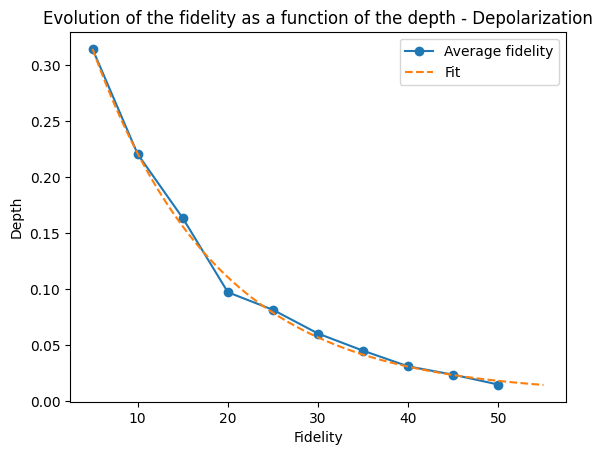

In [ ]:
A, P, B = curve_fit(fidelity_fit, Xm, fidelity_m)[0]
XXm = np.linspace(5, 55, 100)

plt.plot(Xm, fidelity_m, 'o-', label = "Average fidelity")
plt.plot(XXm, fidelity_fit(XXm, A, P, B), '--', label = "Fit")
plt.legend()
plt.title("Evolution of the fidelity as a function of the depth - Depolarization")
plt.xlabel("Fidelity")
plt.ylabel("Depth")

In [ ]:
print("A = ", A)
print("P = ", P)
print("B = ", B)

A =  0.44202819834437956
P =  0.9304089904614337
B =  0.006113063330228894


**Evolution as a Function of Depth for Relaxation**

In [ ]:
dict_noise = [relaxation]

In [ ]:
n_repeat = 50
n_qubit = 5
circuit = QuantumCircuit(n_qubit)
p = 0.05
Xm = np.arange(5, 55, 5)

fidelity_matrix = np.zeros((len(Xm), n_repeat))

for m in tqdm(range(len(Xm))):
  for k in range(n_repeat):
    fidelity_matrix[m, k] = circuit.benchmark(Xm[m], p)

fidelity_m = np.average(fidelity_matrix, axis = 1)

100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Text(0, 0.5, 'Depth')

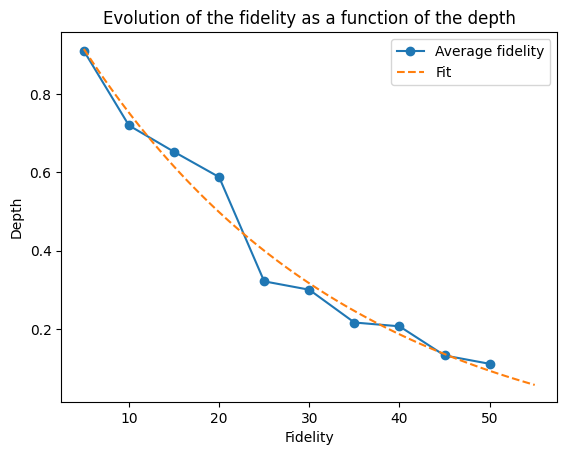

In [ ]:
A, P, B = curve_fit(fidelity_fit, Xm, fidelity_m)[0]
XXm = np.linspace(5, 55, 100)

plt.plot(Xm, fidelity_m, 'o-', label = "Average fidelity")
plt.plot(XXm, fidelity_fit(XXm, A, P, B), '--', label = "Fit")
plt.legend()
plt.title("Evolution of the fidelity as a function of the depth - Relaxation")
plt.xlabel("Fidelity")
plt.ylabel("Depth")

In [ ]:
print("A = ", A)
print("P = ", P)
print("B = ", B)

A =  1.2481325631440823
P =  0.9671173413059998
B =  -0.14079850526287174


**Evolution as a Function of Depth for Bit Flip & Pure Dephasing**

In [ ]:
dict_noise = [pure_dephasing, bit_flip]

In [ ]:
n_repeat = 50
n_qubit = 5
circuit = QuantumCircuit(n_qubit)
p = 0.1
Xm = np.arange(5, 55, 5)

fidelity_matrix = np.zeros((len(Xm), n_repeat))

for m in tqdm(range(len(Xm))):
  for k in range(n_repeat):
    fidelity_matrix[m, k] = circuit.benchmark(Xm[m], p)

fidelity_m = np.average(fidelity_matrix, axis = 1)

100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


Text(0, 0.5, 'Depth')

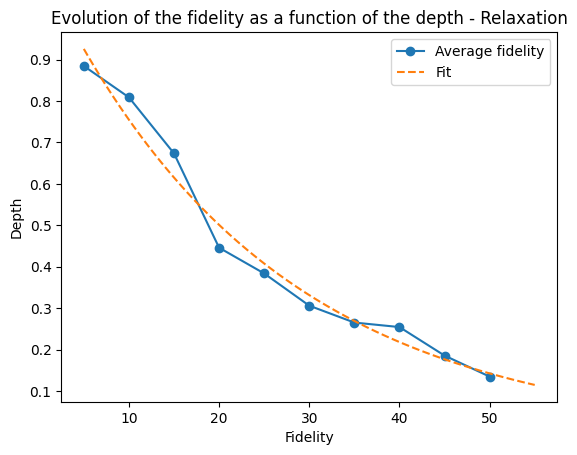

In [ ]:
A, P, B = curve_fit(fidelity_fit, Xm, fidelity_m)[0]
XXm = np.linspace(5, 55, 100)

plt.plot(Xm, fidelity_m, 'o-', label = "Average fidelity")
plt.plot(XXm, fidelity_fit(XXm, A, P, B), '--', label = "Fit")
plt.legend()
plt.title("Evolution of the fidelity as a function of the depth - Bit Flip and Pure dephasing")
plt.xlabel("Fidelity")
plt.ylabel("Depth")

In [ ]:
print("A = ", A)
print("P = ", P)
print("B = ", B)

A =  1.1444037240392975
P =  0.9604637249768488
B =  -0.009567272836320312


**Relation between p and P**

In [ ]:
dict_noise = [depolarizing]

In [ ]:
n_repeat = 100
n_qubit = 5
circuit = QuantumCircuit(n_qubit)
p_r = np.arange(0.01, 0.2, 0.01)
Xm = np.arange(5, 55, 5)

fidelity_matrix = np.zeros((len(p_r),len(Xm), n_repeat))

for idx in tqdm(range(len(p_r))):
  for m in range(len(Xm)):
    for k in range(n_repeat):
      fidelity_matrix[idx, m, k] = circuit.benchmark(Xm[m], p_r[idx])

fidelity_pm = np.average(fidelity_matrix, axis = -1)

100%|██████████| 19/19 [06:54<00:00, 21.80s/it]


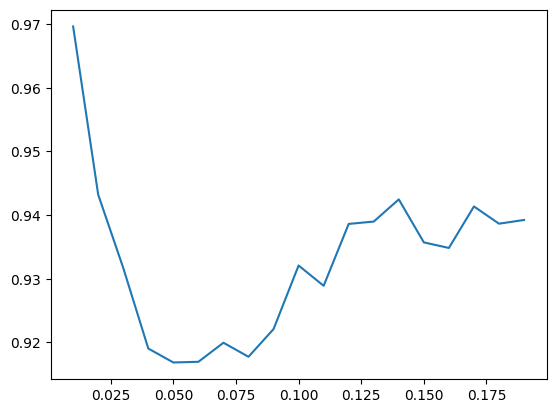

In [ ]:
P_r = np.zeros(len(p_r))
for idx in range(len(p_r)):
  A, P_r[idx], B = curve_fit(fidelity_fit, Xm, fidelity_pm[idx])[0]
plt.plot(p_r, P_r)